# Property Maintenance Fines 

**Predicting the probability that a set of blight tickets will be paid on time**

**Supervised Learning. Classification**

Source: [Applied Machine Learning in Python | Coursera](https://www.coursera.org/learn/python-machine-learning). Solved with classical machine learning classifiers [here](https://github.com/angelmtenor/applied-ML-coursera/blob/master/4_property_maintenance_fines.ipynb)

Data provided by Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)), the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) and the City of Detroit [Detroit Open Data Portal](https://data.detroitmi.gov/).
 

Each row of the dataset   corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. 

**Features**
    
    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
** Labels **

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction]
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helper
import keras

helper.info_gpu()
#sns.set_palette("GnBu_d")
#helper.reproducible(seed=0) # Setup reproducible results from run to run using Keras

%matplotlib inline

Using TensorFlow backend.


/device:GPU:0
Keras		v2.1.3
TensorFlow	v1.4.1


##  1. Data Processing

In [2]:
data_path = 'data/property_maintenance_fines_data.csv'
target = ['compliance']

df_original = pd.read_csv(data_path, encoding='iso-8859-1', dtype='unicode')
print("{} rows \n{} columns \ntarget: {}".format(*df_original.shape, target))

250306 rows 
34 columns 
target: ['compliance']


### Explore and Clean the target

In [3]:
print(df_original[target].squeeze().value_counts(dropna=False))

0.0    148283
NaN     90426
1.0     11597
Name: compliance, dtype: int64


In [4]:
# Remove rows with NULL targets

df_original = df_original.dropna(subset=target)

print(df_original[target].squeeze().value_counts())
print(df_original.shape)

0.0    148283
1.0     11597
Name: compliance, dtype: int64
(159880, 34)


** Imbalanced target: the evaluation metric used in this problem is the Area Under the ROC Curve **

###  Split original data into training and validation test set

In [5]:
from sklearn.model_selection import train_test_split

df, df_test = train_test_split(
    df_original, test_size=0.2, stratify=df_original[target], random_state=0)

** To avoid data leakage, only the training dataframe, df, will be explored and processed here** 

### Show the training data

In [6]:
df.head(2)

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
131030,159232,Department of Public Works,"Montgomery-Coit, Kimberlye","JOHNSON-GREENE, MARGUSIE F.",11645.0,LAKEPOINTE,NaN,11645,LAKEPOINTE,DETROIT,...,0.0,85.0,85.0,0.0,2008-09-12 00:00:00,PAID IN FULL,NaN,NaN,non-compliant by late payment more than 1 month,0.0
29573,49039,"Buildings, Safety Engineering & Env Department","Watson, Jerry","BAPT CHURCH, HOLY TABERNACLE",3184.0,CANFIELD,NaN,3184,E. CANFIELD,DETROIT,...,0.0,305.0,305.0,0.0,2007-06-26 00:00:00,PAID IN FULL,NaN,NaN,non-compliant by late payment more than 1 month,0.0


#### Missing values

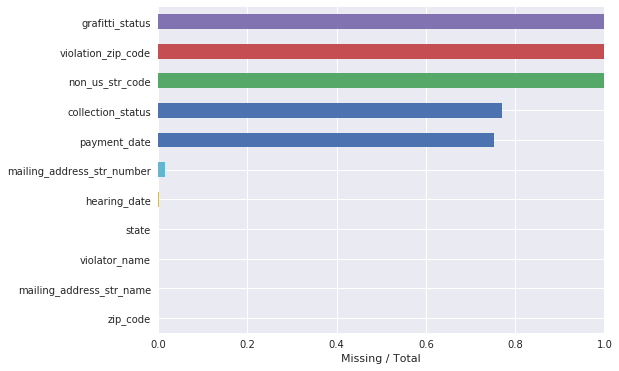

In [7]:
helper.missing(df)

### Transform Data

#### Remove irrelevant features

In [8]:
def remove_features(df):

    relevant_col = ['agency_name', 'violation_street_name', 'city', 'state', 'violator_name',
        'violation_code', 'late_fee', 'discount_amount', 'judgment_amount', 'disposition',
        'fine_amount', 'compliance']

    df = df[relevant_col]

    return df


df = remove_features(df)

print(df.shape)

(127904, 12)


#### Classify variables

In [9]:
num = ['late_fee', 'discount_amount', 'judgment_amount', 'fine_amount']

df = helper.classify_data(df, target, numerical=num)

pd.DataFrame(dict(df.dtypes), index=["Type"])[df.columns].head()  # show data types

numerical features:   4
categorical features: 7
target 'compliance': category


,late_fee,discount_amount,judgment_amount,fine_amount,agency_name,violation_street_name,city,state,violator_name,violation_code,disposition,compliance
Type,float32,float32,float32,float32,category,category,category,category,category,category,category,category


#### Remove low-frequency categorical values

In [10]:
df, dict_categories = helper.remove_categories(df, target=target, ratio=0.001, show=False)

####  Fill missing values

Missing categorical values filled by 'Other'
There are no numerical missing values

In [11]:
df = helper.fill_simple(df, target, missing_categorical='Other') 

Missing categorical filled with label: "Other"


In [12]:
helper.missing(df);

No missing values found


### Visualize the data

#### Categorical features

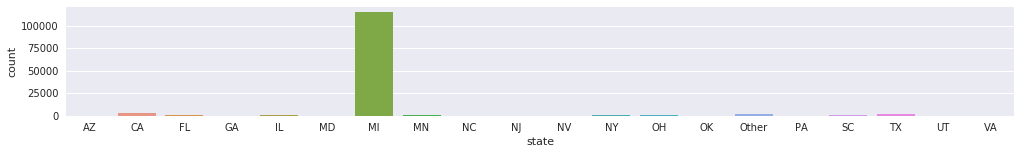

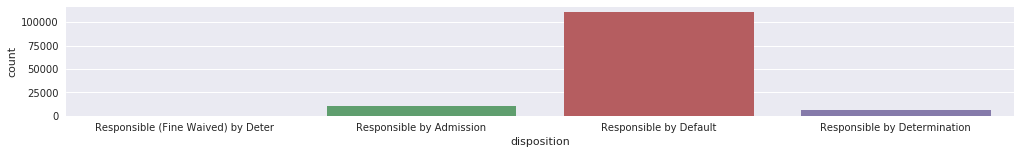

In [13]:
for i in ['state', 'disposition']:
    helper.show_categorical(df[[i]])

#### Numerical features

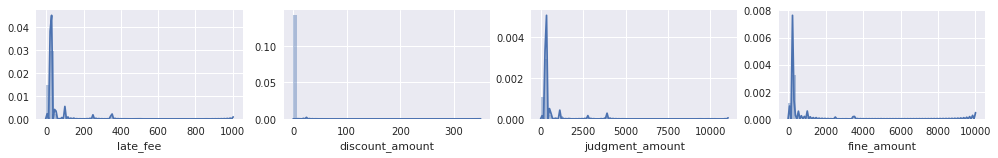

In [14]:
helper.show_numerical(df, kde=True)

## 2. Neural Network Model

### Select the features

In [15]:
droplist = []  # features to drop

# For the model 'data' instead of 'df'
data = df.copy()
# del(df)
data.drop(droplist, axis='columns', inplace=True)
data.head(2)

,late_fee,discount_amount,judgment_amount,fine_amount,agency_name,violation_street_name,city,state,violator_name,violation_code,disposition,compliance
131030,5.0,0.0,85.0,50.0,Department of Public Works,LAKEPOINTE,DETROIT,MI,Other,9-1-103(C),Responsible by Determination,0.0
29573,25.0,0.0,305.0,250.0,"Buildings, Safety Engineering & Env Department",Other,DETROIT,MI,Other,9-1-36(a),Responsible by Default,0.0


### Scale numerical variables
Shift and scale numerical variables to a standard normal distribution. The scaling factors are saved to be used for predictions.

In [16]:
data, scale_param = helper.scale(data)

### Create dummy features
Replace categorical features (no target) with dummy features

In [17]:
data, dict_dummies = helper.replace_by_dummies(data, target)

model_features = [f for f in data if f not in target]  # sorted neural network inputs

data.head(3)

,late_fee,discount_amount,judgment_amount,fine_amount,compliance,"agency_name_Buildings, Safety Engineering & Env Department",agency_name_Department of Public Works,agency_name_Detroit Police Department,agency_name_Health Department,agency_name_Other,...,violation_code_9-1-43(a) - (Dwellin,violation_code_9-1-43(a) - (Structu,violation_code_9-1-81(a),violation_code_9-1-82(d) - (Dwellin,violation_code_Other,disposition_Responsible (Fine Waived) by Deter,disposition_Responsible by Admission,disposition_Responsible by Default,disposition_Responsible by Determination,disposition_Other
131030,-0.422306,-0.049474,-0.451255,-0.453714,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
29573,-0.126339,-0.049474,-0.154289,-0.156975,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2657,-0.126339,-0.049474,-0.154289,-0.156975,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Split the data into training and validation sets

In [18]:
val_size = 0.2
random_state = 0


def validation_split(data, val_size=0.25):

    train, test = train_test_split(
        data, test_size=val_size, random_state=random_state, stratify=data[target])

    # Separate the data into features and target (x=features, y=target)
    x_train, y_train = train.drop(target, axis=1).values, train[target].values
    x_val, y_val = test.drop(target, axis=1).values, test[target].values
    # _nc: non-categorical yet (needs one-hot encoding)

    return x_train, y_train, x_val, y_val


x_train, y_train, x_val, y_val = validation_split(data, val_size=val_size)

# x_train = x_train.astype(np.float16)
y_train = y_train.astype(np.float16)
# X_val = x_val.astype(np.float16)
y_val = y_val.astype(np.float16)

print("train size \t X:{} \t Y:{}".format(x_train.shape, y_train.shape))
print("val size \t X:{} \t Y:{}".format(x_val.shape, y_val.shape))

train size 	 X:(102323, 445) 	 Y:(102323, 1)
val size 	 X:(25581, 445) 	 Y:(25581, 1)


In [19]:
def separate_x_y(data):
    """ Separate the data into features and target (x=features, y=target) """

    x, y = data.drop(target, axis=1).values, data[target].values
    x = x.astype(np.float16)
    y = y.astype(np.float16)
   
    return x, y


# x_train, y_train = separate_x_y(data)

In [20]:
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc


def scores(y_test, y_pred):
    """ Print  different scores """
    print()
    print('Accuracy: \t{:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Precision: \t{:.2f}'.format(precision_score(y_test, y_pred)))
    print('Recall: \t{:.2f}'.format(recall_score(y_test, y_pred)))
    print('\n Confusion matrix: \n', confusion_matrix(y_test, y_pred))

### Dummy classifier

In [21]:
from sklearn.dummy import DummyClassifier

# Negative class (0) is most frequent
%time clf = DummyClassifier(strategy='most_frequent').fit(x_train, np.ravel(y_train))
# Therefore the dummy 'most_frequent' classifier always predicts class 0
y_pred = clf.predict(x_val).reshape([-1, 1])

scores(y_val, y_pred)

CPU times: user 979 ms, sys: 87.7 ms, total: 1.07 s
Wall time: 1.07 s

Accuracy: 	0.93
Precision: 	0.00
Recall: 	0.00

 Confusion matrix: 
 [[23725     0]
 [ 1856     0]]


/home/angel/anaconda3/envs/gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### Random forest classifier (best of grid search)

In [22]:
from sklearn.ensemble import RandomForestClassifier


%time clf_random_forest_opt = RandomForestClassifier(n_estimators = 30, max_features=150, \
                                max_depth=13, class_weight='balanced', n_jobs=-1, \
                                   random_state=0).fit(x_train, np.ravel(y_train))

CPU times: user 28.9 s, sys: 80.2 ms, total: 29 s
Wall time: 8.47 s


In [23]:
y_train_pred = clf_random_forest_opt.predict(x_train).reshape([-1, 1])
print('Random forest training ROC AUC: \t{:.2f} \n'.format(roc_auc_score(y_train, y_train_pred)))

Random forest training ROC AUC: 	0.76 



### Neural Network classifier

In [24]:
def one_hot_output(y_train, y_val):
    num_classes = len(np.unique(y_train))
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_val = keras.utils.to_categorical(y_val, num_classes)
    return y_train, y_val


y_train, y_val = one_hot_output(y_train, y_val)

In [25]:
from sklearn.utils import class_weight

y_plain = np.ravel(y_train[:,1])

cw = class_weight.compute_class_weight('balanced', np.unique(y_plain), y_plain)

cw = {idx : value for idx, value in enumerate(cw)}

In [ ]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout


def build_nn(input_size, output_size, summary=False):

    input_nodes = input_size//8

    model = Sequential()
    model.add(
        Dense(
            input_nodes,
            input_dim=input_size,
            activation='relu'))  
    
    model.add(
        Dense(
            output_size,
            activation='softmax'))

    if summary:
        model.summary()

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model


model = build_nn(x_train.shape[1], y_train.shape[1], summary=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 55)                24530     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 112       
Total params: 24,642
Trainable params: 24,642
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import os
from time import time
model_path = os.path.join("models", "detroit.h5")


def train_nn(model, x_train, y_train, validation_data=None, path=False, show=True):
    """ 
    Train the neural network model. If no validation_datais provided, a split for validation
    will be used
    """
    
    if show:
        print('Training ....')
    
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=1)]
    t0 = time()

    history = model.fit(
        x_train,
        y_train,
        epochs=100,
        batch_size=2048,
        
        class_weight = cw,
        
        verbose=1,
        validation_split=0.3,
        validation_data = validation_data,
        callbacks=callbacks)

    if show:
        print("time: \t {:.1f} s".format(time() - t0))
        helper.show_training(history)

    if path:
        model.save(path)
        print("\nModel saved at", path)
    
    return history
        

model = None
model = build_nn(x_train.shape[1], y_train.shape[1], summary=False)
train_nn(model, x_train, y_train, path=None, show=None);


y_pred_train = model.predict(x_train, verbose=1)
print('\n\n ROC_AUC train:\t{:.2f} \n'.format(roc_auc_score(y_train, y_pred_train)))

y_pred_val = model.predict(x_val, verbose=1)
print('\n\n ROC_AUC val:\t{:.2f}'.format(roc_auc_score(y_val, y_pred_val)))

Train on 71626 samples, validate on 30697 samples
Epoch 1/100
69632/71626 [============================>.] - ETA: 0s - loss: 0.6300 - acc: 0.5649

## Validation Test set

In [ ]:
df_test.head(2)

#### Process validation test data with training parameters (no data leakage)

In [ ]:
df_test = remove_features(df_test)

In [ ]:
df_test = helper.classify_data(df_test, target, numerical=num)

In [ ]:
df_test, _ = helper.remove_categories(
    df_test, target=target, show=False, dict_categories=dict_categories)

In [ ]:
df_test = helper.fill_simple(df_test, target, missing_categorical='Other') 

In [ ]:
df_test, _ = helper.scale(df_test, scale_param)
df_test, _ = helper.replace_by_dummies(df_test, target, dict_dummies)

In [ ]:
df_test = df_test[model_features+target] # sort columns to match training features order

In [ ]:
x_test, y_test = separate_x_y(df_test)

####  Random Forest Validation test

In [ ]:
y_pred = clf_random_forest_opt.predict_proba(x_test)[:,1]
print('Random forest ROC AUC test: \t{:.2f} \n'.format(roc_auc_score(y_test, y_pred)))
scores(y_test, (y_pred>0.5).astype(int))

#### Neural Network validation test

In [ ]:
y_pred = model.predict(x_test, verbose=1)[:,1]
print('\n\n Neural Network ROC AUC test: \t{:.2f} \n'.format(roc_auc_score(y_test, y_pred)))
scores(y_test, (y_pred>0.5).astype(int))